# Custom Preprocessing
Preprocessors take the place of (and are children of) PyTorch's Dataset classes. A preprocessor class performs all of the preprocessing steps from loading a file from the disk up to providing a sample to PyTorch as a Tensor. They are designed to be flexible and modular, so that each step of the preprocessing pipeline can be modified or removed. You'll need to use a preprocessor class when you (a) train a machine learning model in OpenSoundscape, or (b) make predictions with a machine learning model in OpenSoundscape. 

This notebook demonstrates how to use the flexibility of Preprocessor classses to 
- modify audio and spectrogram parameters
- change the output image shape
- turn augmentations on and off
- modify augmentation parameters
- use the overlay augmentation 
- modify the preprocessing pipeline
- change the output type
- write custom preprocessors and actions

In [1]:
# Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learing model
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor

#other utilities and packages
from opensoundscape.helpers import run_command
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

set manual seeds for pytorch and python - you probably don't want to do this when you actually train your model, but it's useful for debugging

In [2]:
torch.manual_seed(0)
random.seed(0)

In [3]:
# helper function for displaying a sample as an image 
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

## Prepare audio data

### Download labeled audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. Download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [42]:
commands = [
    "curl -L https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz -o ./woodcock_labeled_data.tar.gz",
    "tar -xzf woodcock_labeled_data.tar.gz", # Unzip the downloaded tar.gz file
    "rm woodcock_labeled_data.tar.gz" # Remove the file after its contents are unzipped
]
for command in commands:
    run_command(command)

### generate 1-hot encoded labels 

The folder contains 2s long audio clips taken from an autonomous recording unit. It also contains a file `woodcock_labels.csv` which contains the names of each file and its corresponding label information, created using a program called [Specky](https://github.com/rhine3/specky).

We first manipulate the label dataframe to give "one hot" labels - that is, a column for every class, with 1 for present or 0 for absent in each sample's row. In this case, our classes are simply 'negative' for files without a woodcock and 'positive' for files with a woodcock.  Note that these classes are mutually exclusive, so we have a "single-target" problem (as opposed to a "multi-target" problem where multiple classes can simultaneously be present). 

In [4]:
#load Specky output: a table of labeled audio files
labels = pd.read_csv(Path("woodcock_labeled_data/woodcock_labels.csv"))

#update the paths to the audio files
labels.filename = ['./woodcock_labeled_data/'+f for f in labels.filename]

#generate "one-hot" labels
labels['negative']=[0 if label=='present' else 1 for label in labels['woodcock']]
labels['positive']=[1 if label=='present' else 0 for label in labels['woodcock']]

#use the file path as the index, and class names as the only columns
labels = labels.set_index('filename')[['negative','positive']]
labels.head()

negative  positive
filename                                                              
./woodcock_labeled_data/d4c40b6066b489518f8da83...         0         1
./woodcock_labeled_data/e84a4b60a4f2d049d73162e...         1         0
./woodcock_labeled_data/79678c979ebb880d5ed6d56...         0         1
./woodcock_labeled_data/49890077267b569e142440f...         0         1
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5...         0         1

## Intro to Preprocessors
The currently implemented Preprocessor classes include 
- CnnPreprocessor - loads audio files, creates spectrograms, performs various augmentations, and returns a pytorch Tensor.

- AudioToSpectrogramPreprocessor - loads audio files, creates spectrograms, and returns a pytorch Tensor (no augmentation). 

A Preprocessor must be initialized with a very specific dataframe: 
- the index of the dataframe provides paths to audio samples
- the columns are the class names
- the values are 0 (absent/False) or 1 (present/True) for each sample and each class.

For example, we've set up the labels dataframe with files as the index and classes as the columns, so we can use it to make an instance of CnnPreprocessor:

In [5]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

preprocessor = CnnPreprocessor(labels)

### subsetting samples from a Preprocessor
Preprocessors allow you to select a subset of samples using sample() and head() methods (like Pandas DataFrames). For example:

In [6]:
len(preprocessor)

29

In [7]:
len(preprocessor.head(5))

5

In [8]:
len(preprocessor.sample(n=10))

10

In [9]:
len(preprocessor.sample(frac=0.5))

14

## Pipeline and Actions
Preprocessors are flexible - you can add new steps or change parameters. Various examples are shown below. 

**actions**

The preprocessor's `.actions` contains the set of all "actions" objects available to the preprocessor
- an action has a .go() method that takes a sample (and its labels*), performs some transformation, and returns the sample (and its labels*)
- an action has .params dictionary holding parameters for performing the transformation
- the parameters of .params can be modified by using .set(param=value,param2=value2,....)
- you can turn an action on or off (bypass) using the `.on()` and `.off()` methods
- each action is an instance of a class that has BaseAction as a parent, see the `actions` module for examples

**pipeline**

The preprocessor's `.pipeline` is the ordered list of Actions that the preprocessor performs on each sample. 

- You can modify the contents or order of Preprocessor actions by overwriting the preprocessor's `.pipeline` attribute 
- `.pipeline` must always be a list of Actions, where each Action is an instance of a class that sub-classes `opensoundscape.preprocess.BaseAction`

**parameters**

Each Action has allows you to set parameters like this: `action.set(param=value, param2=value)`

### view the actions and pipeline of a preprocessor

In [10]:
# print all actions that have been added to the preprocessor
# (Note that this is not the pipeline, just a collection of available actions)
preprocessor.actions.list_actions()

['load_audio',
 'trim_audio',
 'to_spec',
 'bandpass',
 'to_img',
 'to_tensor',
 'normalize',
 'overlay',
 'color_jitter',
 'random_affine',
 'time_mask',
 'frequency_mask',
 'add_noise']

In [11]:
# inspect the current pipeline (ordered sequence of actions to take)
preprocessor.pipeline

### View default parameters for an action
the docstring for an action, such as train_dataset.actions.to_spec, gives information on what parameters can be changed. 

In [12]:
preprocessor.actions.to_spec?

Type:        AudioToSpectrogram
String form: <opensoundscape.preprocess.actions.AudioToSpectrogram object at 0x141188210>
File:        ~/opensoundscape/opensoundscape/preprocess/actions.py
Docstring:  
Action child class for Audio.from_file() (Audio -> Spectrogram)

see spectrogram.Spectrogram.from_audio for documentation

Args:
    window_type="hann":
        see scipy.signal.spectrogram docs for description of window parameter
    window_samples=512:
        number of audio samples per spectrogram window (pixel)
    overlap_samples=256:
        number of samples shared by consecutive windows
    decibel_limits = (-100,-20) :
    limit the dB values to (min,max)
    (lower values set to min, higher values set to max)


## Audio and Spectrogram Parameters
Below are various examples of how to modify parameters of the AudioLoader, AudioToSpectrogram, and SpectrogramBandpass actions

### Modify the sample rate 
Re-sample all loaded audio to a specified rate during the load_audio action

In [13]:
preprocessor.actions.load_audio.set(sample_rate=24000)

#we can check that the values were actually changed by printing the action's params
print(preprocessor.actions.load_audio.params)

{'sample_rate': 24000}


### Modify spectrogram window length and overlap
(see Spectrogram.from_audio() for detailed documentation)

default parameters:


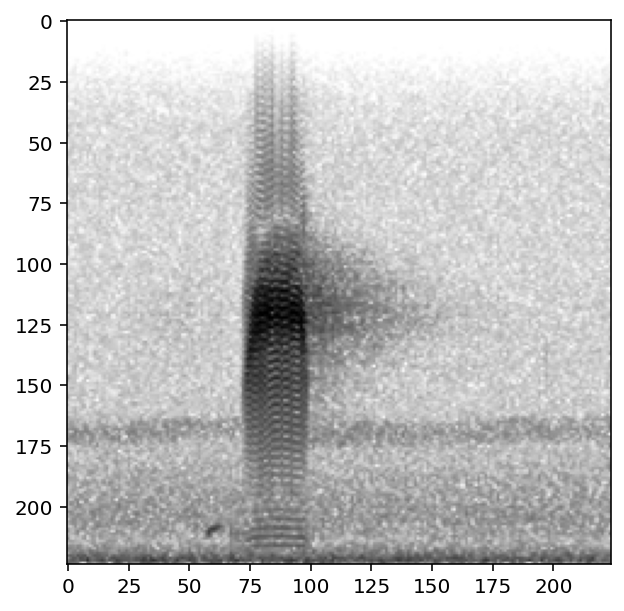

high time resolution, low frequency resolution:


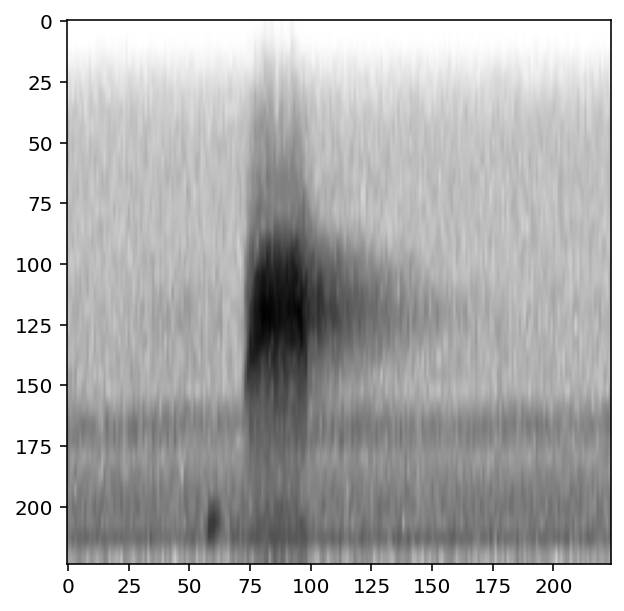

In [14]:
preprocessor = AudioToSpectrogramPreprocessor(labels)

print('default parameters:')
show_tensor(preprocessor[0])

print('high time resolution, low frequency resolution:')
preprocessor.actions.to_spec.set(window_samples=64,overlap_samples=32)

show_tensor(preprocessor[0])

### Bandpass spectrograms
Trim spectrograms to a specified frequency range

default parameters:


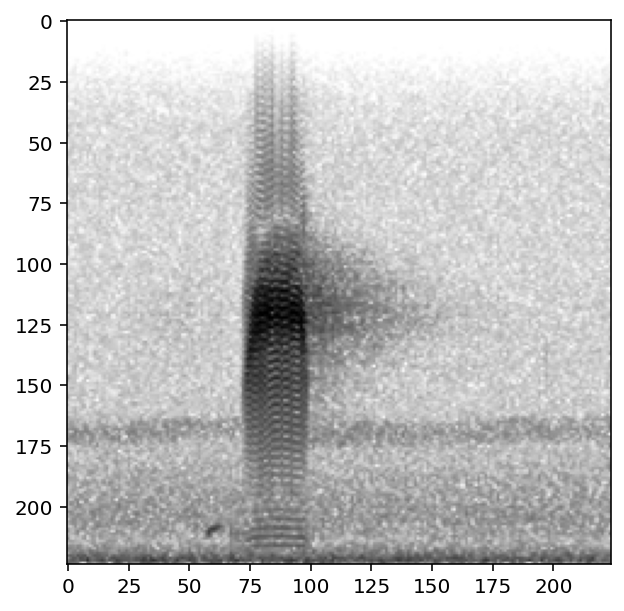

bandpassed to 2-4 kHz:


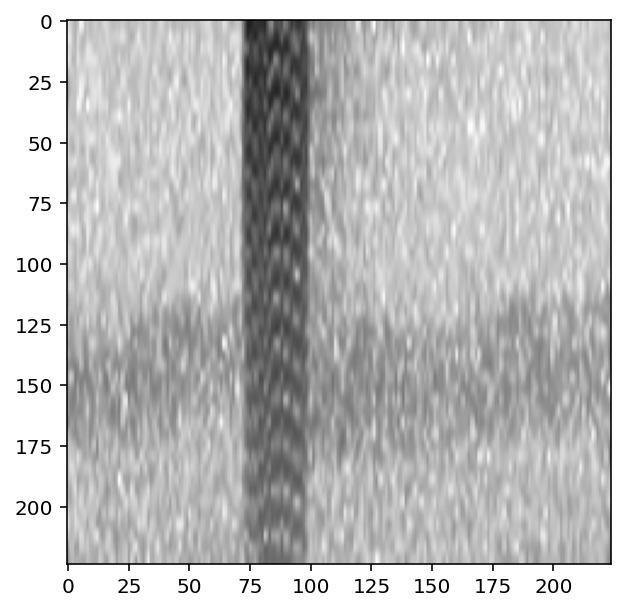

In [15]:
preprocessor = AudioToSpectrogramPreprocessor(labels)

print('default parameters:')
show_tensor(preprocessor[0])

print('bandpassed to 2-4 kHz:')
preprocessor.actions.bandpass.set(min_f=2000,max_f=4000)
preprocessor.actions.bandpass.on()
show_tensor(preprocessor[0])

## Changing the output image

### change the shape of the output image

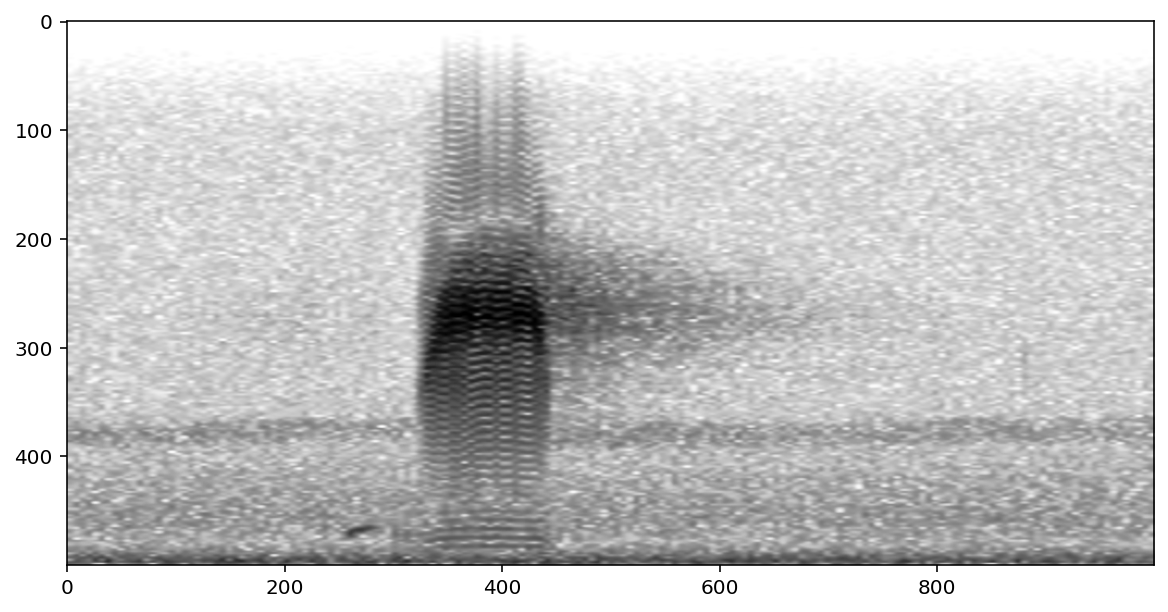

In [16]:
preprocessor = AudioToSpectrogramPreprocessor(labels)
preprocessor.actions.to_img.set(shape=[1000,500])
show_tensor(preprocessor[0])

## Customizing Augmentation

### Turn all augmentation on or off
With CnnPreprocessor, we can easily switch between a pipeline that contains augmentations and a pipeline with no augmentations:

In [17]:
preprocessor = CnnPreprocessor(labels)
preprocessor.augmentation_off()
preprocessor.pipeline

In [18]:
preprocessor.augmentation_on()
preprocessor.pipeline

### Turn individual actions on or off
Each action has `.on()` and `.off()` methods which toggle a bypass of the action in the pipeline:

random affine on


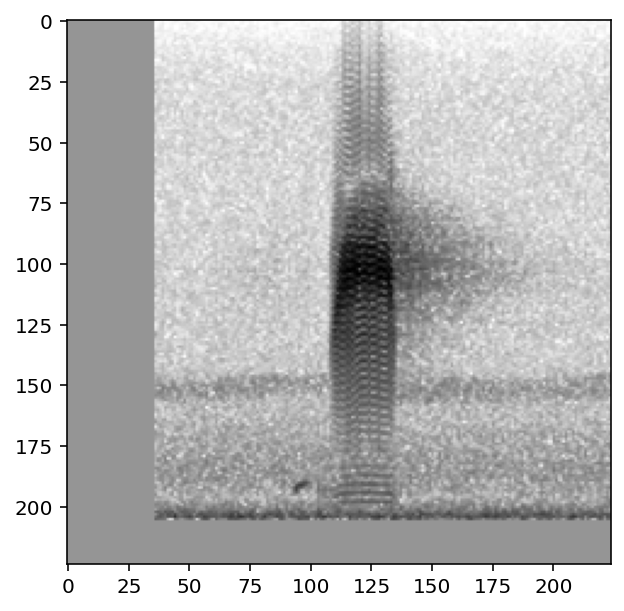

random affine off


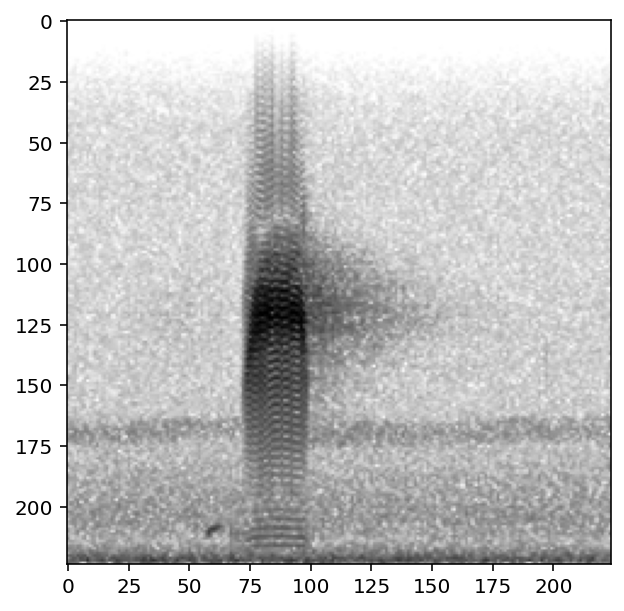

In [19]:
#initialize a preprocessor that includes augmentation
preprocessor = CnnPreprocessor(labels)

#turn off augmentations other than noise
preprocessor.actions.color_jitter.off()
preprocessor.actions.add_noise.off()
preprocessor.actions.time_mask.off()
preprocessor.actions.frequency_mask.off()

print('random affine on')
show_tensor(preprocessor[0])

print('random affine off')
preprocessor.actions.random_affine.off()
show_tensor(preprocessor[0])


### Modifying augmentation parameters
CnnPreprocessor includes several augmentations with customizable parameters. Here we provide a couple of illustrative examples - see any action's documentation for details on how to use its parameters. 

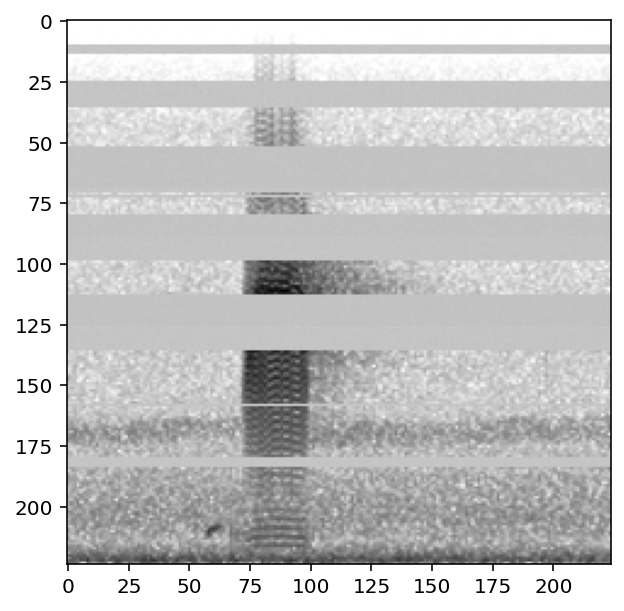

In [20]:
#initialize a preprocessor
preprocessor = CnnPreprocessor(labels)

#turn off augmentations other than overlay
preprocessor.actions.color_jitter.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.time_mask.off()

# allow up to 20 horizontal masks, each spanning up to 0.1x the height of the image. 
preprocessor.actions.frequency_mask.set(max_width = 0.1, max_masks=20)
show_tensor(preprocessor[0])

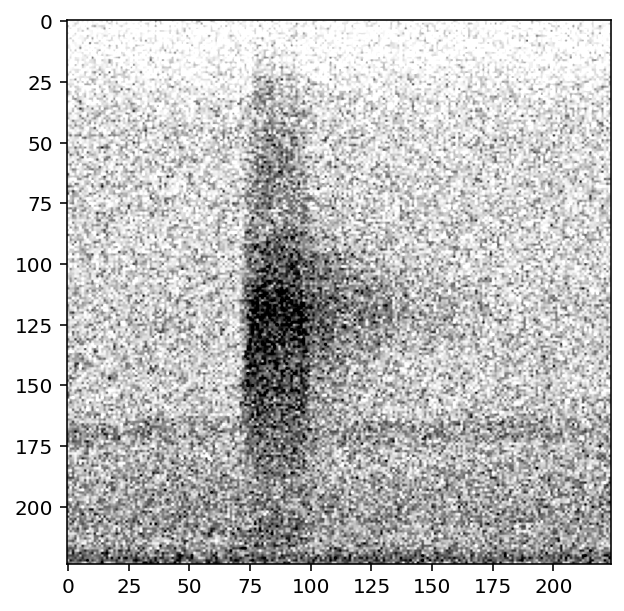

In [21]:
#turn off frequency mask and turn on gaussian noise
preprocessor.actions.add_noise.on()
preprocessor.actions.frequency_mask.off()

# increase the intensity of gaussian noise added to the image
preprocessor.actions.add_noise.set(std=0.2)
show_tensor(preprocessor[0])

## Overlay Augmentation
Overlay is a powerful action that allows additional samples to be overlayed or blended with the original sample. 

The additional samples are chosen from the overlay_df that is provided to the preprocessor when it is initialized. 

Samples are chosen based on their class labels, according to the parameter overlay_class:
- None - Randomly select any file from overlay_df
- "different" - Select a random file from overlay_df containing none
    of the classes this file contains
- specific class name - always choose files from this class

Overlays can be used in a few general ways (each is demonstrated below):

1. a separate df where any file can be overlayed (overlay_class=None)

2. same df as training, where the overlay class is "different" ie, does not contain overlapping labels with the original sample

3. same df as training, where samples from a specific class are used for overlays

The overlay_df can be simply an index containing audio files (no columns), or can have the same columns as the sample df for the preprocessor. 

By default, the overlay Action does **not** change the labels of the sample it modifies. However, if you wish to add the labels from overlayed samples to the original sample's labels, you can set `update_labels=True` (see example below)

In [22]:
#initialize a preprocessor and provide a dataframe with samples to use as overlays
preprocessor = CnnPreprocessor(labels,overlay_df=labels)

#turn off augmentations other than overlay
preprocessor.actions.color_jitter.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.random_affine.off()
preprocessor.actions.time_mask.off()
preprocessor.actions.frequency_mask.off()

### Modifying overlay_weight
by default, the overlay Action chooses a random file from the overlay df. Let's choose a sample from the class called "negative" using the overlay_class parameter. 

We'll first overlay a random sample with 30% of the final mix coming from the overlayed sample (70% original) by using `overlay_weight=0.3`

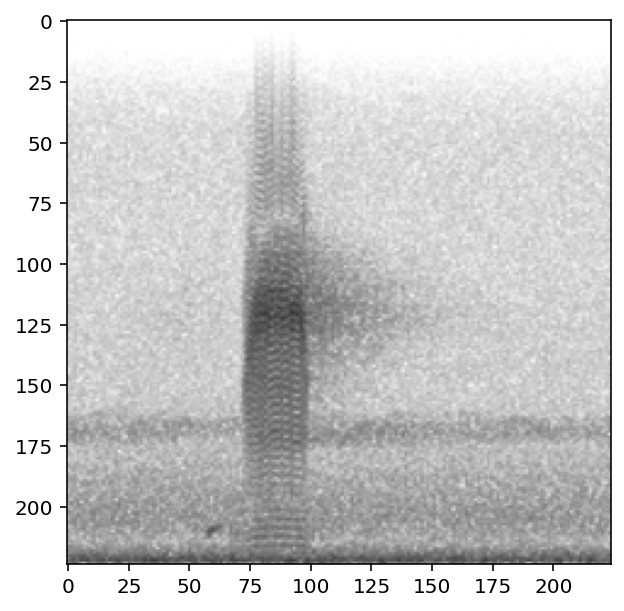

In [23]:
preprocessor.actions.overlay.set(overlay_weight=0.3,overlay_class='negative')
show_tensor(preprocessor[0])

let's now use `overlay_weight=0.8` to increase the contribution of the overlayed sample (80%) compared to the original sample (20%). 

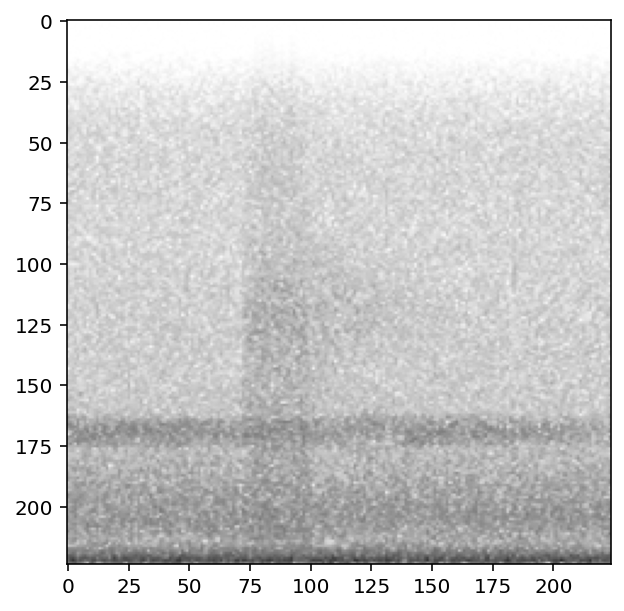

In [24]:
preprocessor.actions.overlay.set(overlay_weight=0.8)
show_tensor(preprocessor[0])

### Overlaying samples from a "different" class
the 'different' option for `overlay_class` chooses a sample to overlay that has non-overlapping labels with the original sample. 

we'll again use `overlay_weight=0.8` to exaggerate the importance of the overlayed sample (80%) compared to the original sample (20%). 

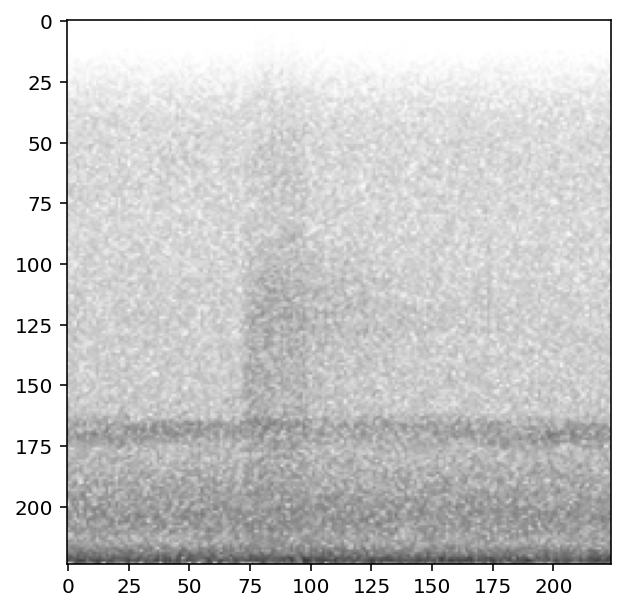

In [25]:
preprocessor.actions.overlay.set(update_labels=False,overlay_class='different',overlay_weight=0.8)
show_tensor(preprocessor[0])

### Overlaying samples from any class
by default, or by specifying overlay_class=None, the overlay sample is chosen randomly from the overlay_df with no restrictions

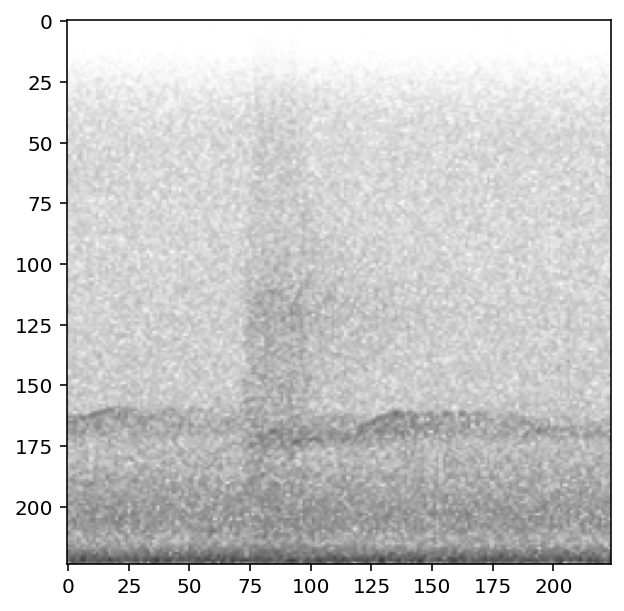

In [26]:
preprocessor.actions.overlay.set(overlay_class=None)
show_tensor(preprocessor[0])

### Updating labels 
By default, the overlay Action does **not** change the labels of the sample it modifies. 

(For instance, if the overlayed sample has labels [1,0] and the original sample has labels [0,1], the default behavior will return a sample with labels [0,1] not [1,1]). 

If you wish to add the labels from overlayed samples to the original sample's labels, you can set `update_labels=True`

In [27]:
print('default: labels do not update')
preprocessor.actions.overlay.set(update_labels=False,overlay_class='different')
print(f"\t resulting labels: {preprocessor[0]['y'].numpy()}")

print('Using update_labels=True')
preprocessor.actions.overlay.set(update_labels=True,overlay_class='different')
print(f"\t resulting labels: {preprocessor[0]['y'].numpy()}")


default: labels do not update
	 resulting labels: [0 1]
Using update_labels=True
	 resulting labels: [1 1]


## Modifying the pipeline
Sometimes, you may want to change the order or composition of the Preprocessor's pipeline. You can simply overwrite the `.pipeline` attribute, as long as the new pipeline is still a list of Action instances from the preprocessor's `.actions` ActionContainer. 

### Returning a Spectrogram instead of a Tensor
Here's an example where we replace the pipeline with one that just loads audio and converts it to a Spectrogram, returning a Spectrogram instead of a Tensor:

original pipeline:

new pipeline:

we now have a preprocessor that returns Spectrograms instead of Tensors:
<class 'opensoundscape.spectrogram.Spectrogram'>


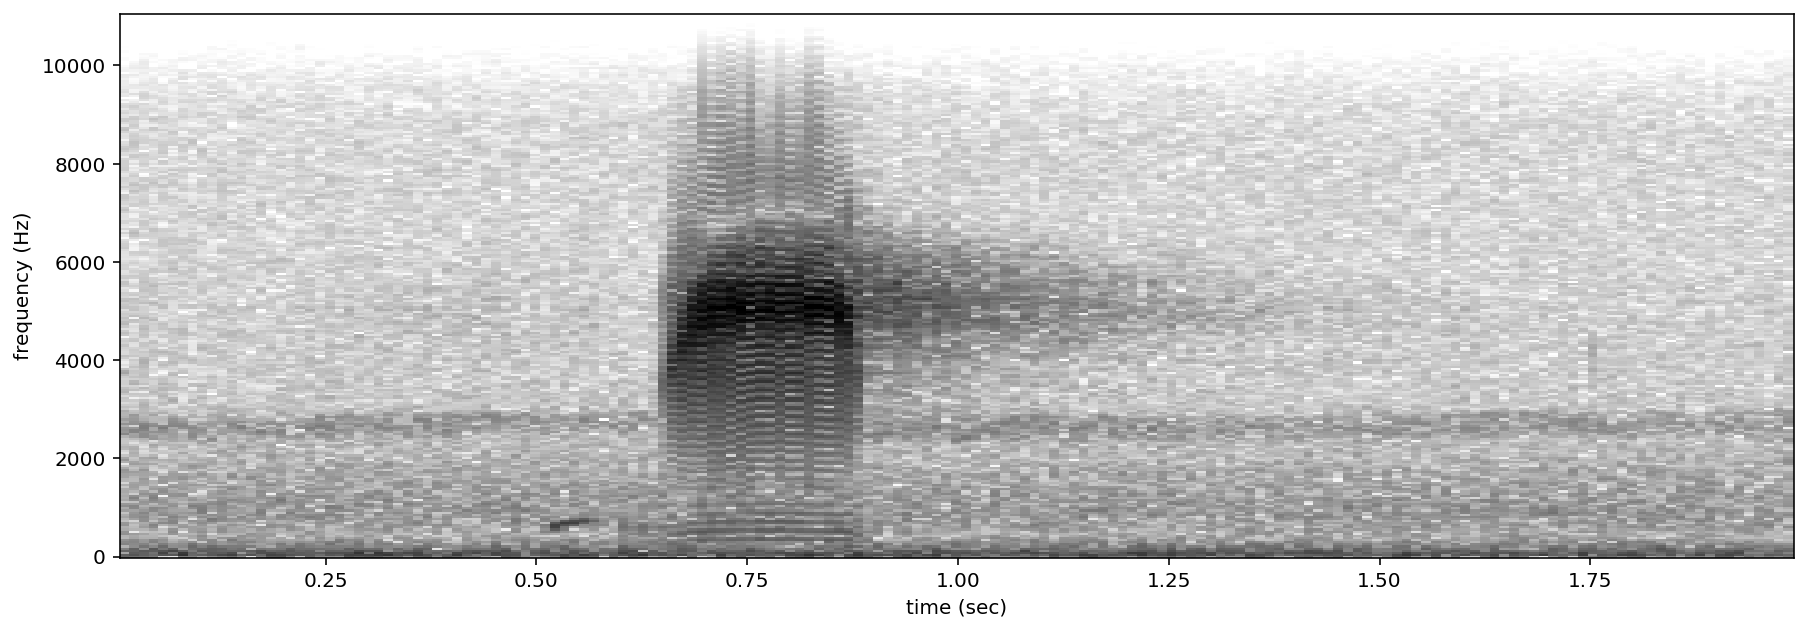

In [28]:
#initialize a preprocessor 
preprocessor = AudioToSpectrogramPreprocessor(labels)
print('original pipeline:')
[print(p) for p in preprocessor.pipeline]

#overwrite the pipeline with a slice of the original pipeline
print('\nnew pipeline:')
preprocessor.pipeline = preprocessor.pipeline[0:3]

[print(p) for p in preprocessor.pipeline]

print('\nwe now have a preprocessor that returns Spectrograms instead of Tensors:')
print(type(preprocessor[0]['X']))
preprocessor[0]['X'].plot()

### Custom Augmentation Pipeline
Here's an example where we add a new action to the action container, then overwrite the preprocessing pipeline with one that includes our new action. 

Note that each action requires a specific input Type and may return that same Type or a different Type. So you'll need to be careful about the order of your Actions in your pipeline

This custom pipeline will first performs a Gaussian noise augmentation, then a random affine, then our second noise augmentation (add_noise_2)

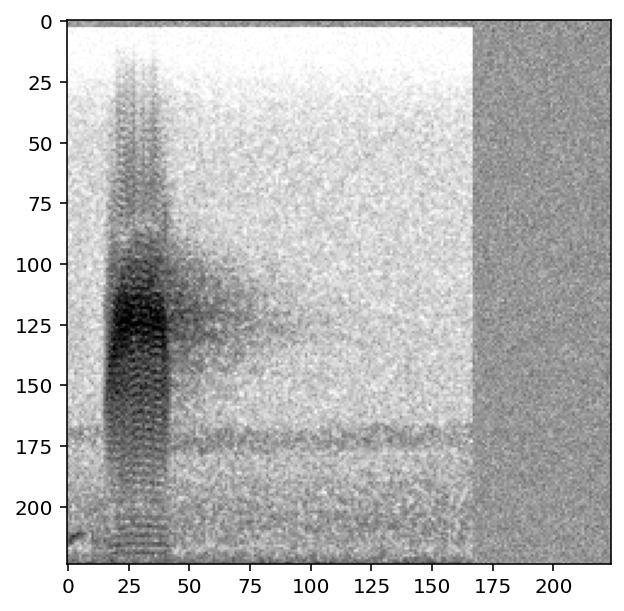

In [29]:
#initialize a preprocessor
preprocessor = CnnPreprocessor(labels)

#add a new action to the action container
from opensoundscape.preprocess.actions import TensorAddNoise
preprocessor.actions.add_noise_2 = TensorAddNoise(std=0.1)

#overwrite the pipeline with a list of Actions from .actions 
preprocessor.pipeline = [
    preprocessor.actions.load_audio,
    preprocessor.actions.trim_audio,
    preprocessor.actions.to_spec,
    preprocessor.actions.bandpass,
    preprocessor.actions.to_img,
    preprocessor.actions.to_tensor,
    preprocessor.actions.normalize,
    preprocessor.actions.add_noise,
    preprocessor.actions.random_affine,
    preprocessor.actions.add_noise_2
]

show_tensor(preprocessor[0])

## Creating a new Preprocessor class
If you have a specific augmentation routine you want to perform, you may want to create your own Preprocessor class rather than modifying an existing one. 


Your subclass might add a different set of Actions, define a different pipeline, or even override the __getitem__ method of BasePreprocessor. 

Here's an example of a customized preprocessor that subclasses AudioToSpectrogramPreprocessor and creates a pipeline that depends on the `magic_parameter` input. 

In [30]:
from opensoundscape.preprocess.actions import TensorAddNoise
class MyPreprocessor(AudioToSpectrogramPreprocessor):
    """Child of AudioToSpectrogramPreprocessor with weird augmentation routine"""
    
    def __init__(
        self,
        df,
        magic_parameter,
        audio_length=None,
        return_labels=True,
        out_shape=[224, 224],
    ):

        super(MyPreprocessor, self).__init__(
            df,
            audio_length=audio_length,
            out_shape=out_shape,
            return_labels=return_labels,
        )

        self.actions.add_noise = TensorAddNoise(std=0.1*magic_parameter)

        self.pipeline = [
            self.actions.load_audio,
            self.actions.trim_audio,
            self.actions.to_spec,
            self.actions.bandpass,
            self.actions.to_img,
            self.actions.to_tensor,
            self.actions.normalize,
        ] + [self.actions.add_noise for i in range(magic_parameter)]

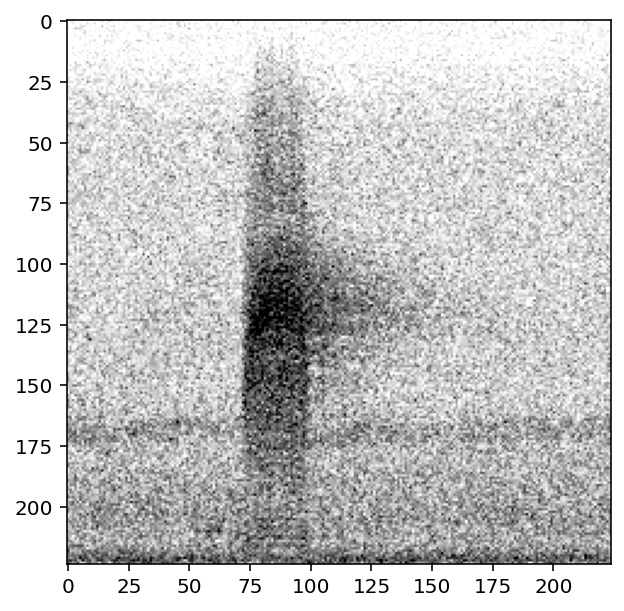

In [31]:
p = MyPreprocessor(labels,2)
show_tensor(p[0])

## Defining new Actions
You can define new Actions to include in your Preprocessor pipeline - they should subclass opensoundscape.actions.BaseAction

### simple example
If the action does not need to have default arguments, it's trivial to create

In [32]:
from opensoundscape.preprocess.actions import BaseAction
class SquareSamples(BaseAction):
    """Square values of every audio sample
    
    Audio in, Audio out
    """
    def go(self, audio):
        samples = np.array(audio.samples)**2
        return Audio(samples, audio.sample_rate)

test it out

In [34]:
from opensoundscape.audio import Audio

square_action = SquareSamples(threshold=0.2)

audio = Audio.from_file('./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav')
print(np.mean(audio.samples))
audio = square_action.go(audio)
print(np.mean(audio.samples))

0.012753859
0.008748752


### complete example
Here we overwrite the `__init__` method to provide a default parameter value

In [37]:
class AudioGate(BaseAction):
    """Replace audio samples below a threshold with 0
    
    Audio in, Audio out
    
    Args: 
        threshold: sample values below this will become 0
    """

    def __init__(self, **kwargs):
        super(AudioGate, self).__init__(**kwargs)
        
        # default parameters
        self.params["threshold"] = 0.1
        
        # update/add any parameters passed to __init__
        self.params.update(kwargs)
    
    def go(self, audio):
        samples = np.array([0 if np.abs(s)<self.params["threshold"] else s for s in audio.samples])
        return Audio(samples, audio.sample_rate)

histogram of samples


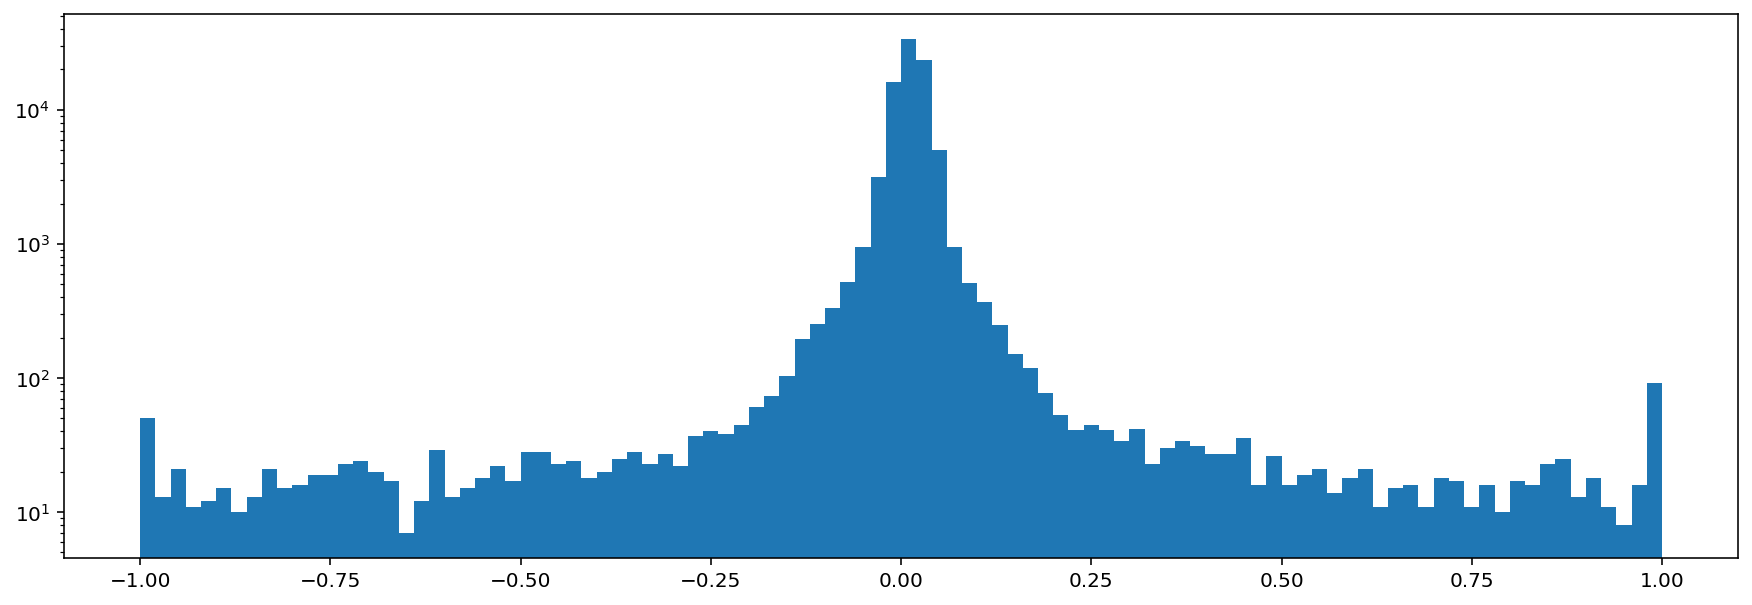

histogram of samples after audio gate


[]

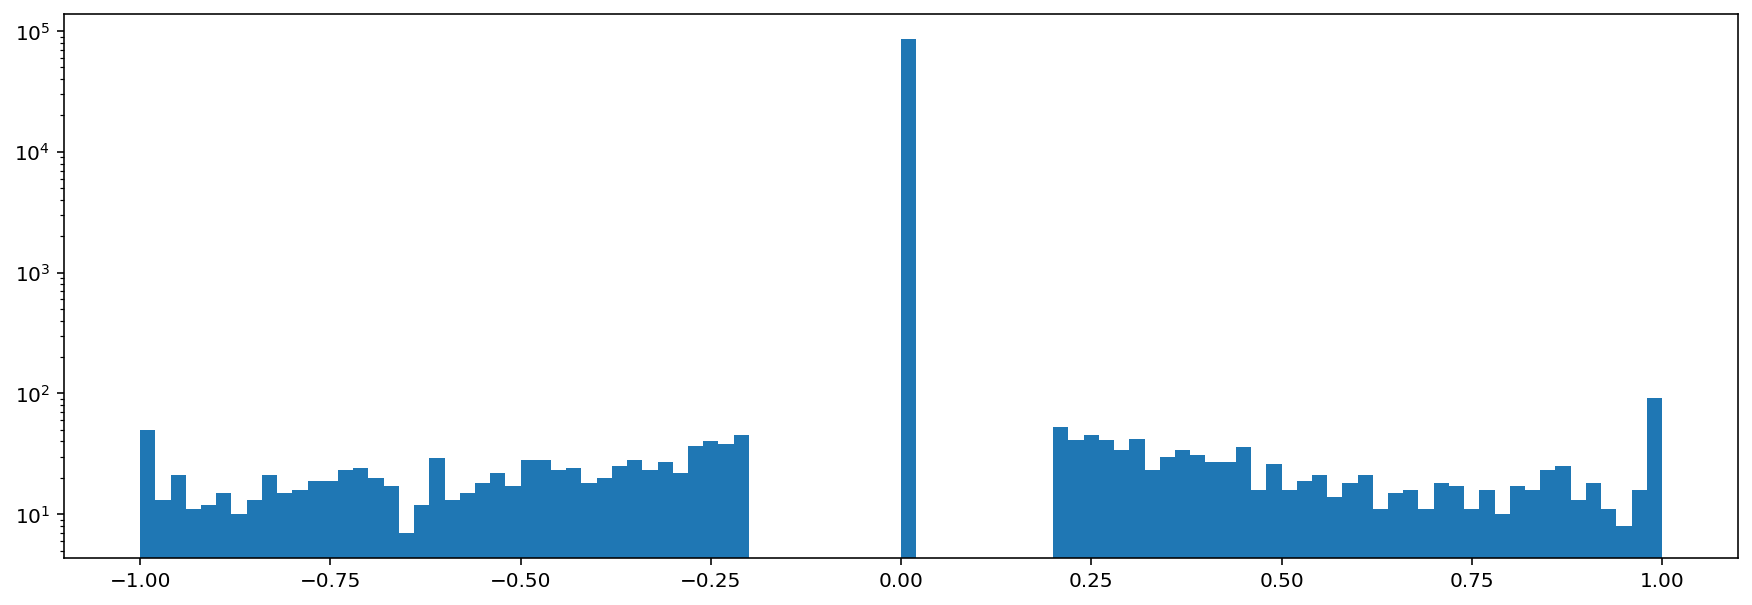

In [36]:
gate_action = AudioGate(threshold=0.2)

print('histogram of samples')
audio = Audio.from_file('./woodcock_labeled_data/01c5d0c90bd4652f308fd9c73feb1bf5.wav')
_ = plt.hist(audio.samples,bins=100)
plt.semilogy()
plt.show()

print('histogram of samples after audio gate')
audio_gated = gate_action.go(audio)
_ = plt.hist(audio_gated.samples,bins=100)
plt.semilogy()